If running on colab:

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!ln -s "/gdrive/My Drive/ColabNotebooks/ml-project-2-sigmoid-fraud/data/" "/content/data"
!ln -s "/gdrive/My Drive/ColabNotebooks/ml-project-2-sigmoid-fraud/scripts/" "/content/scripts"

Mounted at /gdrive


In [2]:
from data import mask_to_submission
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
import os
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler, random_split
import albumentations as album
%matplotlib inline

from scripts.preprocessing import *
from scripts.evaluation import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
from scripts.models import *
from scripts.training import *
masa_info = pd.read_csv('data/derivatives/masachussetts_info.csv')

import torch
import torchvision
from torchvision import models
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def human_readable(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{:.2f}{}'.format(num, ['', 'K', 'M', 'B', 'T'][magnitude])

cuda


# Project Road Segmentation

For this choice of project task, we provide a set of satellite images acquired
from GoogleMaps. We also provide ground-truth images where each pixel is labeled
as road or background.

Your task is to train a classifier to segment roads in these images, i.e.
assigns a label `road=1, background=0` to each pixel.

Submission system environment setup:

1. The dataset is available from the
[AICrowd page](https://www.aicrowd.com/challenges/epfl-ml-road-segmentation).

2. Obtain the python notebook `segment_aerial_images.ipynb` from this github
folder, to see example code on how to extract the images as well as
corresponding labels of each pixel.

The notebook shows how to use `scikit learn` to generate features from each
pixel, and finally train a linear classifier to predict whether each pixel is
road or background. Or you can use your own code as well. Our example code here
also provides helper functions to visualize the images, labels and predictions.
In particular, the two functions `mask_to_submission.py` and
`submission_to_mask.py` help you to convert from the submission format to a
visualization, and vice versa.

3. As a more advanced approach, try `tf_aerial_images.py`, which demonstrates
the use of a basic convolutional neural network in TensorFlow for the same
prediction task.

Evaluation Metric:
 [F1 score](https://en.wikipedia.org/wiki/F1_score)


### Example Image

(400, 400, 3) (400, 400, 3)


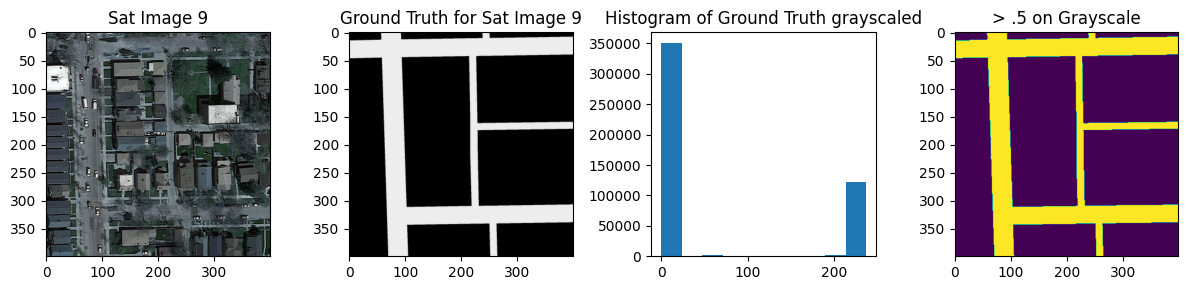

In [5]:
img_idx = 9
im = cv.imread(f'data/training/images/satImage_00{img_idx}.png')
im_gt = cv.imread(f'data/training/groundtruth/satImage_00{img_idx}.png')
im_gt_gs = np.where(color.rgb2gray(im_gt) > .5, 1, 0)

fig, ax = plt.subplots(1, 4, figsize = (12, 3))
ax[0].imshow(im)
ax[0].set_title(f"Sat Image {img_idx}")
ax[1].imshow(im_gt)
ax[1].set_title(f"Ground Truth for Sat Image {img_idx}")
ax[2].hist(im_gt.flatten(), bins = 10)
ax[2].set_title('Histogram of Ground Truth grayscaled')
ax[3].imshow(im_gt_gs)
ax[3].set_title('> .5 on Grayscale')


print(im.shape, im_gt.shape,)
plt.tight_layout()
plt.show()

##Table of contents

<font size = 3> The task is **semantic segmentation**, and in this particular case binary classification of road pixels. For images this means generating a 2d mask of binary values for 1: road and 0: other pixels. To solve this task our project will use the following methods and follow this plan as a road map to success:
> ### 0) Helper functions
> ### 1) Random classification
> ### 2) Dummy classifier
> ### 3) Image processing algorithm
> ### 4) Classic machine learning techniques with custom feature vectors
> > ##### i) Feature extraction
> > ##### ii) Linear Regression
> > ##### iii) Logistic Regression
> > ##### iv) Additional Method
> > ##### v) Model comparison and statistics
> ### 5) Convolutional Neural Networks
> >  #### i) Classic CNN. VGG13
> > #### ii) U-Net CNN. https://arxiv.org/pdf/1505.04597.pdf
> > #### iii) Competition Submission
> > #### iv) Data Augmentation
> > > ##### a) Data Augmentation (Rotating, Flipping, Crop & Resize, Gaussian Noise and other generated Corruptions)
> > > ##### b) Dataset complementation with Masachussetts or DeepGlobe
> > > ##### c) Model comparison
> > #### v) Favorite Model Variations
> ### 6) Transfer Learning

## 1) Random Classifier

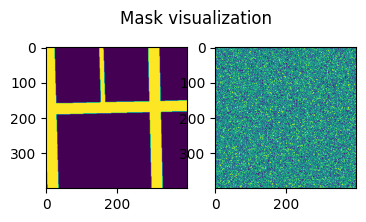

{'Accuracy': 0.4985625,
 'Precision': 0.2327914259691325,
 'Recall': 0.49891702542984734,
 'F1-score': 0.31745869702074087}

In [ ]:
#Fixed seed
np.random.seed(7)

def RandomClassifier(input_img):
    output_mask = (np.random.rand(input_img.shape[0],input_img.shape[1]) > 0.5) * 255
    return color.gray2rgb(output_mask)

#No need to generalize to the whole dataset, we simply calculate the accuracy for 1 image
predicted_mask = parse_mask_to_binary( RandomClassifier(im))

fig, ax = plt.subplots(1, 2, figsize = (4, 8))
ax[0].imshow(im_gt_gs)
ax[1].imshow(predicted_mask)
fig.suptitle("Mask visualization", y = 0.63)
plt.show()

metrics(y_pred = predicted_mask.flatten(), y = im_gt_gs.flatten())

So as hypothesized, the random classifier has an accuracy of ~50%, and this is the case of a single image from the training set where we luckily have a similar number of road/background pixels ratio = 1. This is a nice benchmark to understand the dataset and compare our models to, but nothing else.

## 2) Dummy Classifier

What is a dummy classifier in our case? Well, one could see it as an emperical statistical estimation of what a road pixel should look like and then classifying all pixels through this condition.

One of the most straight forward dummy classifiers we can make is to take a look at our image's color histograms and deduce an empiricala condition on this.

We have 3 different channels per image R, G, B. but since roads are mostly gray, we can take a look at at a computed hue or HSV channel or even just the grayscale channel

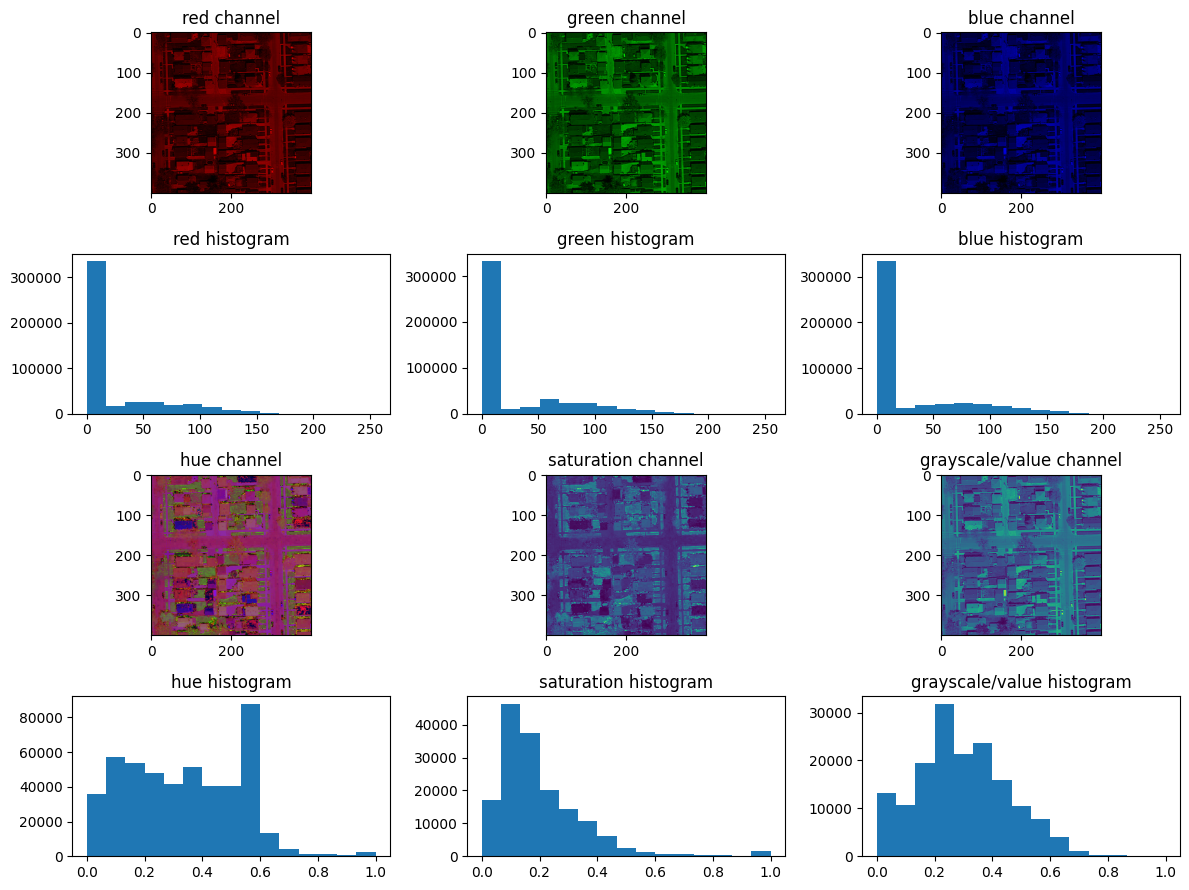

In [ ]:
im_red_channel = im.copy()
im_red_channel[:, :, 1] = 0
im_red_channel[:, :, 2] = 0

im_green_channel = im.copy()
im_green_channel[:, :, 0] = 0
im_green_channel[:, :, 2] = 0

im_blue_channel = im.copy()
im_blue_channel[:, :, 0] = 0
im_blue_channel[:, :, 1] = 0

im_hsv = color.rgb2hsv(im)
im_hue_channel = im_hsv[:, :, 0]
im_saturation_channel = im_hsv[:, :, 1]

im_grayscale = color.rgb2gray(im)


channels = {"red": im_red_channel, "green": im_green_channel, "blue": im_blue_channel, "hue": im_hsv, "saturation": im_saturation_channel,
            "grayscale/value": im_grayscale}

fig, ax = plt.subplots(4, 3, figsize = (12, 9))
for kdx, key in enumerate(channels):
    ax[2*int(kdx/3), kdx%3].imshow(channels[key])
    ax[2*int(kdx/3), kdx%3].set_title(key + " channel")

    ax[2*int(kdx/3) + 1, kdx%3].hist(channels[key].flatten(), bins = 15)
    ax[2*int(kdx/3) + 1, kdx%3].set_title(key + " histogram")

plt.tight_layout()
plt.show()

What we can see is that there are no histogram peaks or bumps for our road pixel values and this is a clear challenge in our task, as the satellite images are taken from a bird's eye view, the house roof's are also gray and of very similar color to the roads, which makes it hard to discern valid barriers.
None the less in our HSV histograms, we seem to have a certain peak at around .15 for the saturation channel, lets see if this generalizes to the rest of the training set.


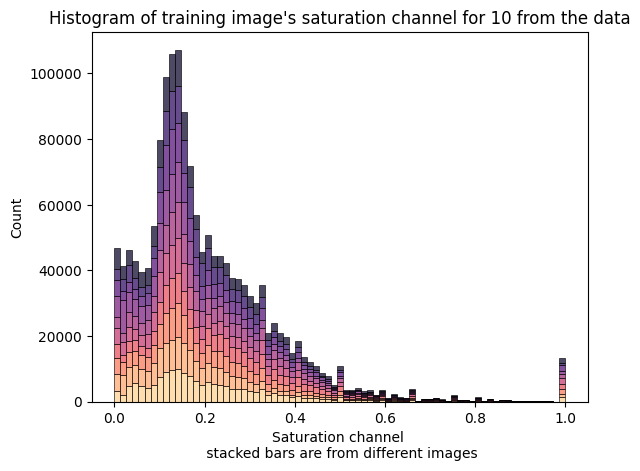

In [ ]:
hue_images = []
n_images = 10 #Take n images as to not overload memory
TRAINING_DIR = "data/training/images/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR)): training_images = sorted(files)

for img_name in training_images[:n_images]:
    img = cv.imread(TRAINING_DIR+img_name)
    hue_images.append(color.rgb2hsv(img)[:,:, 1].flatten()) #Extractng flattened hue pixel values

#hue_images = np.concatenate(hue_images)
sns.histplot(hue_images, bins = 75, palette = sns.color_palette("magma", n_colors=n_images), multiple='stack', legend=False)
plt.title(f"Histogram of training image's saturation channel for {n_images} from the data")
plt.xlabel("Saturation channel \n stacked bars are from different images")
plt.show()


So there seems to be a generalizable trend for our dummy classifier of a peak of values from 0.1 to 0.2 in saturation values, lets make the classifier and evaluate it's performance

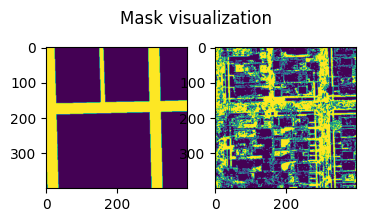

{'Accuracy': 0.67273,
 'Precision': 0.40043,
 'Recall': 0.61594,
 'F1-score': 0.48534}

In [ ]:
def DummyClassifier(input_img):
    saturation_channel = color.rgb2hsv(input_img)[:, :, 1]
    output_mask = np.where((saturation_channel > 0.1) & (saturation_channel < 0.2), 1, 0)
    return output_mask

TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_images = sorted(files)
n_images = 10 #Take n images as to not overload memory

sum_labels = [[], []]
for file_name in training_images[:n_images]:
    img = cv.imread(TRAINING_DIR+'images/'+file_name)

    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file_name)
    predicted_mask = DummyClassifier(img)

    sum_labels[0].append(predicted_mask.flatten())
    sum_labels[1].append(parse_mask_to_binary(groundtruth_mask).flatten())

y_pred = np.concatenate(sum_labels[0])
y = np.concatenate(sum_labels[1])

predicted_mask = DummyClassifier(im)

fig, ax = plt.subplots(1, 2, figsize = (4, 8))
ax[0].imshow(im_gt_gs)
ax[1].imshow(predicted_mask)
fig.suptitle("Mask visualization", y = 0.63)
plt.show()

metrics(y_pred, y)

So these average metrics are already better scores than the random classifier which is nice.

## 3) Image processing algorithm

Having taken a look at the histograms for our dummy classifier, this got us thinking what other image properties and methods we could use. Before neural networks, semantic segmentation worked through smart region growing algorithms with similar pixels of interest. These are methods could work for our task too.

## 4) Classic machine learning techniques
#### i) Feature extraction
#### ii) Linear Regression
#### iii) Logistic Regression

### i) Feature extraction

Images has always been a tricky task for machine learning techniques and thats mainly the image to feature translation task that isn't obvious. In normal linear regression, you input a feature vector of a sample and obtain an output whether that be a classification or regression value to vector. For linear regression you simple cant input a 2d image as an input for a plethora of reasons. The main one being ambiguous dimensions, but also the if the features are simply the pixel values as a flattened vector, we lose our contextual information of the pixel.

In the provided code, we have a feature generation method, based on our RGB channels by dividing our images in linear patches and then infering features from those patches. This is great as we can assume through data inspection that our roads have a minimum width and this saves us alot of computational time.

Here we will try a different avenue of pixel feature generation and perhaps quickly see that this is not viable. (limitations no shape/fourier descriptors)

##### Now we will create our training dataset of with just our patches and train our classifiers with this patch feature dataset

In [ ]:
TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_filenames = sorted(files)

training_data = []
n_patches = 16*16
n_images = 10
for fdx, file in enumerate(training_filenames):

    #patch features
    img = cv.imread(TRAINING_DIR+'images/'+file)
    img_patches = img_to_patches(img, number_of_patches=n_patches)
    patches_features = np.array([patch_to_features(patch) for patch in img_patches])

    #patch labels
    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file)
    mask_patches = img_to_patches(groundtruth_mask, number_of_patches=n_patches)
    mask_labels = np.array([groundtruth_patch_to_label(patch, foreground_threshold=.25) for patch in mask_patches])

    img_data = np.concatenate([patches_features, mask_labels.reshape(-1, 1)], axis = 1)
    if (fdx%10 == 0): print('img number:', fdx)
    training_data.append(img_data)

training_df = pd.DataFrame(np.concatenate(training_data))

print("final dataframe shape:", training_df.shape) #should be (n_images*n_patches, n_features + 1) #without gabor filters n_features = 12
training_df.to_csv('data/derivatives/training_data_custom.csv') #save for later use to not run spaghetti code again

img number: 0
img number: 10
img number: 20
img number: 30
img number: 40
img number: 50
img number: 60
img number: 70
img number: 80
img number: 90
final dataframe shape: (25600, 13)


In [ ]:
training_df = pd.read_csv('data/derivatives/training_data_custom.csv', index_col=0)

scaler = StandardScaler()
training_df.iloc[:, :-1] = scaler.fit_transform(training_df.iloc[:, :-1].values)
display(training_df.sample())

X, y = (training_df.iloc[:, :-1], training_df.iloc[:, -1])

0         1         2         3         4         5         6  \
13831 -0.108991  0.441331 -0.111324  0.511829 -0.057698  0.708747  0.169322   

              7         8        9        10        11   12  
13831  0.712967  0.023806  0.54774 -0.080305  0.641335  1.0

So now we have extracted our features for our training data, we can start looking at our models and evaluating ***training and validation metrics*** for our models

One more note is that cross validation is great for fine tuning, however, we hypothesize that our best model will include CNNs, so we will content ourselves with estimating validation metrics on a train-validation split.

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15)

### ii) Linear Regression

Good ol' linear regression. Let's see how well it does, for this part we'll be using sklearn's SGD Classifier to cycle through classic ML models that we saw for project 1.

Training patches average: {'Accuracy': 0.66742, 'Precision': 0.58856, 'Recall': 0.52438, 'F1-score': 0.55462} 

Validation patches average: {'Accuracy': 0.68307, 'Precision': 0.59214, 'Recall': 0.56203, 'F1-score': 0.5767} 

Predicted mask average (on "whole" training set): {'Accuracy': 0.7401060000000002, 'F1-score': 0.618784}


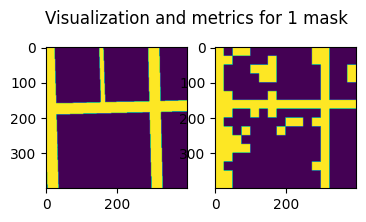

{'Accuracy': 0.875,
 'Precision': 0.67089,
 'Recall': 0.89831,
 'F1-score': 0.76812}

In [ ]:
n_epochs = 1000
linear_classifier = SGDClassifier(loss='squared_error', max_iter=n_epochs, tol=1e-12)
linear_classifier.fit(X_train.values,y_train.values)

training_predictions = linear_classifier.predict(X_train.values)
validation_predictions = linear_classifier.predict(X_validation.values) #difference between patch and mask accuracy

print('Training patches average:', metrics(training_predictions, y_train), '\n')
print('Validation patches average:', metrics(validation_predictions, y_validation), '\n')

print('Predicted mask average:', mask_predictions(scaler=scaler, model=linear_classifier, n_patches=n_patches,
        img_directory="data/training/images", gt_directory="data/training/groundtruth", dataset_size=10))

#visualization for a sample
visualize_predicition(im, im_gt_gs, scaler=scaler, model=linear_classifier,n_patches=n_patches)


Patch size has huge influence and results are quite variable, however we can clearly see a great improvement from our dummy classifier, the predicted mask average accuracy ~74% and F1-score ~61%.

### iii) Logistic Regression


Training patches average: {'Accuracy': 0.69991, 'Precision': 0.65891, 'Recall': 0.49773, 'F1-score': 0.56709} 

Validation patches average: {'Accuracy': 0.71589, 'Precision': 0.66552, 'Recall': 0.52339, 'F1-score': 0.58596} 

Predicted mask average (on "whole" training set): {'Accuracy': 0.7446010000000001, 'F1-score': 0.620268}


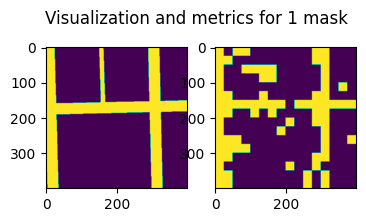

{'Accuracy': 0.84766,
 'Precision': 0.625,
 'Recall': 0.84746,
 'F1-score': 0.71942}

In [ ]:
n_epochs = 100000
logistic_regression= SGDClassifier(loss='log_loss', max_iter=n_epochs, tol=1e-12)
logistic_regression.fit(X_train.values,y_train.values)

training_predictions = logistic_regression.predict(X_train.values)
validation_predictions = logistic_regression.predict(X_validation.values)

print('Training patches average:', metrics(training_predictions, y_train), '\n')
print('Validation patches average:', metrics(validation_predictions, y_validation), '\n')

print('Predicted mask average:', mask_predictions(scaler=scaler, model=logistic_regression, n_patches=n_patches,
        img_directory="data/training/images", gt_directory="data/training/groundtruth", dataset_size=10))

visualize_predicition(im, im_gt_gs, scaler=scaler, model=logistic_regression,n_patches=n_patches)

Logistic regression outperforms linear regression on the patch accuracy and mask accuracy. To be expected.

### iv) Try one last model, ideas: Random forests, SVM, k-NN with cool distance metrics (cosine distance)

### v) Performance statistics & visualization
bar plot of performance recap of each model & accuracy depending on patch size

## 5) Convolutional Neural Networks

Well time to roll up our sleeves.
CNNs leverage convolutional layers to automatically and adaptively learn spatial hierarchies of features from the input data.
Convolution involves applying a set of filters (kernels) to the input image, sliding them across the image, and computing dot products at each location.
The result of the convolution operation is a set of feature maps. Each feature map represents the activation of a particular filter and highlights specific patterns or features present in our satellite images.

Instead of having an ansatz on deciding which filters we're going to use to generate feature vectors, we will learn the filters. cool beans

To custom design & test CNN architectures, we will use pytorch api and library.

>  #### i) Classic CNN. VGG13
> #### ii) U-Net CNN. https://arxiv.org/pdf/1505.04597.pdf
> #### iii) Competition Submission
> #### iv) Data Augmentation
> > ##### a) Data Augmentation (Rotating, Flipping, Crop & Resize, Gaussian Noise and other generated Corruptions)
> > ##### b) Dataset complementation with Masachussetts or DeepGlobe
> > ##### c) Model comparison
> #### v) Favorite Model Variations


### 0) Functions

### i) Classic CNN, VGG-13

The first type of CNNs we'll explore are the classic CNNs used for image classification. We will use their CNN backbone architecture to create nice features for our image. Our task, however, is image segmentation so to adapt the traditional CNN-backbone into a full connected network used for image classification, we will treat our image segmentation as patch-wise image classification.

We know that the Aircrowd submission takes 16x16 patches of our mask as a submission, so we will do the same for our patch-wise classification.

Finally, for the CNN-backbone, there are many well known examples: LeNet, AlexNet, VGG16, GoogLeNet and the ResNet architectures.
We will inspire ourselves off of the **VGG16** CNN architecture. Since image patches though are only 16x16, we will use a reduced architecture also known as VGG13. (For the 13 layers, 10 convolutional and 3 Fully-connected.

In [ ]:
#Create nice patch dataset
TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_filenames = sorted(files)

training_patches, training_labels = ([], [])
patch_size = 16 #according to Aircrowd competition
for fdx, file in enumerate(training_filenames):

    #patch features
    img = cv.imread(TRAINING_DIR+'images/'+file)
    img_patches = img_to_patches_fixed(img, patch_size=patch_size)

    #patch labels
    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file)
    mask_patches = img_to_patches_fixed(groundtruth_mask, patch_size=patch_size)
    #.25 threshold, per provided code
    mask_labels = np.array([groundtruth_patch_to_label(patch, foreground_threshold=.25) for patch in mask_patches])

    training_patches.append(img_patches)
    training_labels.append(mask_labels)
    if (fdx%20 == 0): print('img number:', fdx)

training_patches = np.concatenate(training_patches)
training_labels = np.concatenate(training_labels)
print("dataset shape:", training_patches.shape, "labels shape:" ,training_labels.shape)

np.save('data/derivatives/training_patches.npy', training_patches) #Save data to later not have to rerun this alot
np.save('data/derivatives/training_labels.npy', training_labels)

img number: 0
img number: 20
img number: 40
img number: 60
img number: 80
dataset shape: (62500, 16, 16, 3) labels shape: (62500,)


In [ ]:
training_patches = np.load('data/derivatives/training_patches.npy')
training_labels = np.load('data/derivatives/training_labels.npy')

config = {
    "device": DEVICE,
    "model": "VGG16",
    "patch_size": 16,
    "n_epochs": 50,
    "batch_size": 256,
    "optimizer": "AdamW",
    "loss_function": "CrossEntropy",
    "learning_rate": 1e-4,
    "prediction_transform": "PatchPred",
    "labels_transform": "identity",
    "scheduler": "CosineAnnealing",
    "test_size": 0.1
}

vgg = train_model(X=training_patches, y=training_labels, config=config)

X_train shape: (56250, 16, 16, 3) (56250,)
Epoch: 005 train loss = 0.463275 val loss = 0.499265 train accuracy = 0.8432 val accuracy = 0.8025 validation F1 0.6580
Epoch: 010 train loss = 0.423317 val loss = 0.485404 train accuracy = 0.8864 val accuracy = 0.8230 validation F1 0.7160
Epoch: 015 train loss = 0.401753 val loss = 0.492287 train accuracy = 0.9088 val accuracy = 0.8133 validation F1 0.7249
Epoch: 020 train loss = 0.386783 val loss = 0.482698 train accuracy = 0.9247 val accuracy = 0.8265 validation F1 0.7305
Epoch: 025 train loss = 0.377157 val loss = 0.485824 train accuracy = 0.9348 val accuracy = 0.8233 validation F1 0.7269
Epoch: 030 train loss = 0.369901 val loss = 0.489664 train accuracy = 0.9422 val accuracy = 0.8208 validation F1 0.7178
Epoch: 035 train loss = 0.363642 val loss = 0.492980 train accuracy = 0.9487 val accuracy = 0.8177 validation F1 0.6994
Epoch: 040 train loss = 0.364907 val loss = 0.494873 train accuracy = 0.9473 val accuracy = 0.8112 validation F1 0.71

Predicted mask average: {'Accuracy': 0.9572800000000001, 'F1-score': 0.9380269999999999}


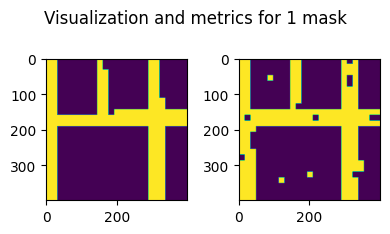

{'Accuracy': 0.9328,
 'Precision': 0.84615,
 'Recall': 0.94624,
 'F1-score': 0.8934}

In [ ]:
print('Predicted mask average:', mask_predictions_vgg(scaler=identity(), model=vgg, n_patches=25*25, img_directory='data/training/images',
                                                  gt_directory='data/training/groundtruth', dataset_size=10))
visualize_predicition_vgg(img=im, gt=im_gt_gs, scaler=identity(), model=vgg, n_patches=25*25)

89% F1-score on our whole training set and we only trained for 85% of the set. Convolutional neural networks are clearly the way to go. The reason the groundtruth looks different here, is that opted to compare the groundtruth that will be used in the AIcrowd competiton. This groundtruth is patched for a patch size of 16 and considered a road labeled patch if the patch has 25% road pixels

### ii) U-Net

Other CNNs have also been made that directly output a mask, and it isn't black magic, these architectures were made famous by the U-Net architecture. Lets try to make our own U-Net.

In [ ]:
#Create nice image dataset
TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_filenames = sorted(files)

training_images, training_image_labels = ([], [])
for fdx, file in enumerate(training_filenames):

    img = cv.imread(TRAINING_DIR+'images/'+file)

    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file)
    groundtruth_mask_binary = parse_mask_to_binary(groundtruth_mask)[:,:,None]

    training_images.append(img)
    training_image_labels.append(groundtruth_mask_binary)
    if (fdx%20 == 0): print('img number:', fdx)


training_images = np.array(training_images)
training_image_labels = np.array(training_image_labels)
print("dataset shape:", training_images.shape, "labels shape:" ,training_image_labels.shape)

np.save('data/derivatives/training_imgs.npy', training_images) #Save data to later not have to rerun this alot
np.save('data/derivatives/training_imgs_labels.npy', training_image_labels)

img number: 0
img number: 20
img number: 40
img number: 60
img number: 80
dataset shape: (100, 400, 400, 3) labels shape: (100, 400, 400, 1)


In [ ]:
training_imgs = np.load('data/derivatives/training_imgs.npy')
training_labels = np.load('data/derivatives/training_imgs_labels.npy')

unet_config = {
    "model": "U-Net",
    "patch_size": 8,
    "n_epochs": 50,
    "batch_size": 10,
    "optimizer": "AdamW",
    "loss_function": "BCELoss",
    "learning_rate": 1e-4,
    "prediction_transform": "identity_detach",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.1
}

unet = train_model(X=training_imgs, y=training_labels, config=unet_config, )

X_train shape: (90, 400, 400, 3) (90, 400, 400, 1)
Epoch: 005 train loss = 0.313694 val loss = 0.350174 train accuracy = 0.6536 val accuracy = 0.6385 validation F1 0.7794
Epoch: 010 train loss = 0.230315 val loss = 0.273693 train accuracy = 0.7061 val accuracy = 0.7643 validation F1 0.8664
Epoch: 015 train loss = 0.187542 val loss = 0.269358 train accuracy = 0.7332 val accuracy = 0.7450 validation F1 0.8539
Epoch: 020 train loss = 0.159896 val loss = 0.252502 train accuracy = 0.7468 val accuracy = 0.8381 validation F1 0.9119
Epoch: 025 train loss = 0.140650 val loss = 0.245365 train accuracy = 0.7774 val accuracy = 0.8376 validation F1 0.9116
Epoch: 030 train loss = 0.123652 val loss = 0.245849 train accuracy = 0.7908 val accuracy = 0.8422 validation F1 0.9144
Epoch: 035 train loss = 0.113116 val loss = 0.237041 train accuracy = 0.8033 val accuracy = 0.8666 validation F1 0.9285
Epoch: 040 train loss = 0.103453 val loss = 0.241788 train accuracy = 0.8213 val accuracy = 0.8538 validation

Predicted mask average: {'Accuracy': 0.9697683999999995, 'F1-score': 0.9317181999999995}


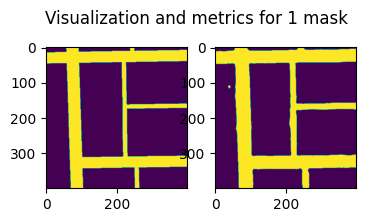

{'Accuracy': 0.95217,
 'Precision': 0.8452,
 'Recall': 0.99983,
 'F1-score': 0.91604}

In [ ]:
print('Predicted mask average:', mask_predictions_unet(model=unet, img_directory='data/training/images',
                                                  gt_directory='data/training/groundtruth'))
visualize_predicition_unet(img=im, gt=im_gt_gs, model=unet)

### iii) **Competition Submission**

In [32]:
def test_masks(test_directory, model, visualize_number=6, deep=False):

  test_filepaths = []
  for root, dirs, files in sorted(os.walk(test_directory))[1:]: test_filepaths.append(root+'/'+files[0])

  model.eval()

  output_masks = [] #Here we go baby
  output_masks_filenames = []
  for fdx, file in enumerate(sorted(test_filepaths)):

    test_img = cv.imread(file)
    test_img = torch.tensor(test_img[:,:,:,None].T, dtype=torch.float32).to(device=DEVICE)

    if (not deep):
      mask = np.where(identity_detach(model(test_img)) > 0.5, 1, 0)[0][0]
    else:
      print(test_img.shape)
      mask = np.where(identity_detach(model(test_img)['out'])>0.5, 1, 0)[0][0]

    if (fdx%5 == 0): print(f"data/test_masks/{file.split('/')[-1]}")
    output_filename = f"data/test_masks/{file.split('/')[-1]}"
    output_masks_filenames.append(output_filename)
    cv.imwrite(output_filename, 255*mask.T)

    output_masks.append(mask.T)

  test_ids =  np.random.choice(len(output_masks), size = visualize_number)

  for i in range(visualize_number):
    plt.figure(figsize = (3, 3))
    test_img = cv.imread(test_filepaths[test_ids[i]])
    out_img = color.gray2rgb(255*output_masks[test_ids[i]])
    #print(test_img, out_img)
    cat_img = np.concatenate([test_img, out_img], axis=1)
    plt.imshow(cat_img)
    plt.show()
  return output_masks, output_masks_filenames

In [24]:
test_directory = "data/test_set_images/"
#predicted_test_masks, mask_filenames = test_masks(test_directory, model = unet,
#                                                  visualize_number=3)

In [ ]:
mask_to_submission.masks_to_submission("data/sub002.csv", *mask_filenames)

### iv) Data Augmentation

> ##### a) Data Augmentation (Rotating, Flipping, Crop & Resize, Gaussian Noise and other generated Corruptions)
> ##### b) Dataset complementation with Masachussetts or DeepGlobe

### a) Data Augmentation (Rotating, Flipping, Crop & Resize, Gaussian Noise and other generated Corruptions)

For this next part, we will perform data augmentation which are random changes to the images and masks of our training dataset to generate "new" images for our model to improve. For this we will be using a dataset class from torch and the albumentations library to generate these augmented images

#### With Dataset class

In [ ]:
class RoadSegDataset(torch.utils.data.Dataset):

    """Read/load images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            augmentation=None,
            preprocessing=None,
            sub_sample=-1
    ):
        if ("+" in images_dir):
          sources_im = images_dir.split('+')
          sources_ma = masks_dir.split('+')

          #Sources 0 will always be masachussetts
          prepend_im = "masachussetts/train/"
          prepend_ma = "masachussetts/train_labels/"
          #print(sorted(os.listdir(sources_im[0])))

          masa_im = [os.path.join(sources_im[0], image_id) for image_id in sorted(os.listdir(sources_im[0]))
           if masa_info[masa_info['im_paths'] == f"{prepend_im}{image_id}"]['corrupted'].values.tolist()[0] == False
                     ][:sub_sample]


          masa_ma = [os.path.join(sources_ma[0], image_id) for image_id in sorted(os.listdir(sources_ma[0]))
           if masa_info[masa_info['ma_paths'] == f"{prepend_ma}{image_id}"]['corrupted'].values.tolist()[0] == False
                     ][:sub_sample]

          self.image_paths = masa_im + [os.path.join(sources_im[1], image_id
              ) for image_id in sorted(os.listdir(sources_im[1]))]
          self.mask_paths = masa_ma + [os.path.join(sources_ma[1], image_id
              ) for image_id in sorted(os.listdir(sources_ma[1]))]
        else:
          self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))][:sub_sample]
          self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))][:sub_sample]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        #print("getting_item", i)
        image = cv.imread(self.image_paths[i]).astype('float32')
        mask = cv.imread(self.mask_paths[i]).astype('float32')

        # apply augmentations
        select_roads = 0
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            select_roads += 1
            gt_ = mask.flatten()
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']


        return image, mask

    def __len__(self):
        return len(self.image_paths)


def unet_labels(y):
  return y.type(torch.float32)

def numpy_and_binarize(x):
    return np.where(x.detach().cpu().numpy() > 0.5, 1, 0)

def split_data(dataset, ratio = 0.9):
  total_size = len(dataset)
  train_size = int(ratio * total_size)
  val_size = total_size - train_size
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
  return train_dataset, val_dataset

def train_model_augmented(x_directory, y_directory, config, use_model=None):

  dataset = RoadSegDataset(x_directory, y_directory, preprocessing = config['preprocessing'], augmentation = config['augmentation'], sub_sample = config['sub_sample'])
  train_dataset, validation_dataset = split_data(dataset, ratio = config['train_size'])
  train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True
                          ,pin_memory=torch.cuda.is_available(), drop_last = True, num_workers = 2)
  validation_loader = DataLoader(validation_dataset, batch_size=config['batch_size'])
  print("Loaded Augmented Dataset Class")

  n_epochs = config['n_epochs']

  device = config['device']
  model_dict = {"VGG16": VGG13, "U-Net": UNET}
  optimizer_dict = {"AdamW": optim.AdamW}
  loss_function_dict = {"CrossEntropy": nn.CrossEntropyLoss, "BCELoss": nn.BCELoss}
  scheduler_dict  = {'CosineAnnealing': torch.optim.lr_scheduler.CosineAnnealingLR}
  scheduler_kwargs_dict = {'CosineAnnealing': dict(T_max = n_epochs*len(train_loader.dataset))}

  #prediction_transform_dict = {"PatchPred": PatchPred, "identity": identity_func, "identity_detach": identity_detach,
                               #"numpy_and_binarize": numpy_and_binarize}
  #labels_transform_dict = {"unet_reshape": unet_labels, "identity": identity_func}


  model = model_dict[config['model']]().to(device=device) #Get model
  if (use_model is not None):
    model = use_model
  optimizer = optimizer_dict[config['optimizer']](model.parameters(), lr = config['learning_rate']) #Get optimizer
  criterion = loss_function_dict[config['loss_function']]() #Get loss function

  scheduler = scheduler_dict[config['scheduler']](optimizer, **scheduler_kwargs_dict[config['scheduler']])

  prediction_transform = config['prediction_transform']
  labels_transform = config['labels_transform']

  metrics_dict = {"training": [], "validation": []}
  print("Starting Epochs")
  for epoch in range(n_epochs):

        #Model training
        model.train()
        train_metrics = {'Accuracy': 0, 'F1-score': 0}
        total_train_loss = 0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            if (epoch == 0): print("batch_idx", batch_idx)
            inputs = inputs.to(device=device) # inputs: torch.Size([batch, C, 400, 400])
            labels = labels.to(device=device) # labels: torch.Size([batch, C, 400, 400])

            optimizer.zero_grad()
            prediction = model(inputs) # [B, C=1, H, W]
            labels = labels_transform(labels) # Binarize + [B, C=1, H, W]

            #print(type(prediction), type(labels))
            loss = criterion(prediction, labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            prediction_class = prediction_transform(prediction) # Binarize
            labels = np.array(labels.detach().cpu().numpy())

            batch_metrics = metrics(prediction_class.flatten(), labels.flatten())
            train_metrics['Accuracy'] += batch_metrics['Accuracy']
            train_metrics['F1-score'] += batch_metrics['F1-score']

        train_metrics['Accuracy'] /= len(train_loader)
        train_metrics['F1-score'] /= len(train_loader)
        average_train_loss = total_train_loss/len(train_loader)

        if (epoch + 1) % 1 == 0:
            model.eval()
            validation_metrics = {'Accuracy': 0, 'F1-score': 0}
            total_validation_loss = 0
            for validation_inputs, validation_labels in validation_loader:
                validation_inputs, validation_labels = (validation_inputs.to(device=device), validation_labels.to(device=device))
                with torch.no_grad():
                    prediction = model(validation_inputs)
                    validation_labels = labels_transform(validation_labels)

                    validation_loss = criterion(prediction, validation_labels)
                    total_validation_loss += validation_loss.item()

                    prediction_class = prediction_transform(prediction)
                    validation_labels = np.array(validation_labels.detach().cpu().numpy())

                    batch_metrics = metrics(prediction_class.flatten(), validation_labels.flatten())
                    validation_metrics['Accuracy'] += batch_metrics['Accuracy']
                    validation_metrics['F1-score'] += batch_metrics['F1-score']

            validation_metrics['Accuracy'] /= len(validation_loader)
            validation_metrics['F1-score'] /= len(validation_loader)
            average_validation_loss = total_validation_loss/len(validation_loader)

            metrics_dict["training"].append(train_metrics)
            metrics_dict["validation"].append(validation_metrics)
            print('Epoch:', '%03d' % (epoch + 1), 'train loss =', '{:.6f}'.format(average_train_loss),
                   'val loss =', '{:.6f}'.format(average_validation_loss),'train accuracy =','{:.4f}'.format(train_metrics['Accuracy']),
                     'val accuracy =','{:.4f}'.format(validation_metrics['Accuracy']), 'validation F1', '{:.4f}'.format(validation_metrics['F1-score']))

  return model, metrics_dict

def unet_preprocess_data(image, mask):

    # Perform any necessary preprocessing for U-net model:
    # Permute dimensions from HWC to CHW, binarize and reduce number of channels

    image = image.transpose(2, 0, 1)

    mask = mask.transpose(2, 0, 1)
    mask = np.where(mask == 0, 0, 1)
    mask = mask[0:1, :, :] #take one channel

    return {'image': image, 'mask': mask}

def data_augmentation_daphne():
    train_transform = [
        album.Rotate(limit=[-180, 180], p=0.75),
        album.RandomResizedCrop(height=400, width=400, scale=(0.8, 1.0), always_apply=True, p=1),
        ]
    return album.Compose(train_transform)

In [ ]:
## Re-running U-Net
unet_config_augmented = {
    "model": "U-Net",
    "preprocessing": unet_preprocess_data,
    "augmentation": data_augmentation_daphne(),
    "patch_size": 16,
    "n_epochs": 200,
    "batch_size": 5,
    "optimizer": "AdamW",
    "loss_function": "BCELoss",
    "learning_rate": 1e-4,
    "prediction_transform": numpy_and_binarize,
    "labels_transform": unet_labels,
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "train_size": .9,
    "sub_sample": None
}

x_directory, y_directory = ("data/training/images", "data/training/groundtruth")
unet_augmented_rotate, metrics_per_epoch = train_model_augmented(x_directory, y_directory, unet_config_augmented)

Loaded Augmented Dataset Class
Starting Epochs
batch_idx 0
batch_idx 1
batch_idx 2
batch_idx 3
batch_idx 4
batch_idx 5
batch_idx 6
batch_idx 7
batch_idx 8
batch_idx 9
batch_idx 10
batch_idx 11
batch_idx 12
batch_idx 13
batch_idx 14
batch_idx 15
batch_idx 16
batch_idx 17
Epoch: 001 train loss = 0.620887 val loss = 0.686988 train accuracy = 0.6628 val accuracy = 0.5044 validation F1 0.4255
Epoch: 002 train loss = 0.518710 val loss = 0.571494 train accuracy = 0.7892 val accuracy = 0.7900 validation F1 0.6426
Epoch: 003 train loss = 0.457140 val loss = 0.527730 train accuracy = 0.8171 val accuracy = 0.8047 validation F1 0.6637
Epoch: 004 train loss = 0.419500 val loss = 0.430061 train accuracy = 0.8348 val accuracy = 0.8373 validation F1 0.6979
Epoch: 005 train loss = 0.392936 val loss = 0.323951 train accuracy = 0.8514 val accuracy = 0.8807 validation F1 0.7531
Epoch: 006 train loss = 0.374750 val loss = 0.333625 train accuracy = 0.8569 val accuracy = 0.8793 validation F1 0.7439
Epoch: 00

KeyboardInterrupt: ignored

Predicted mask average: {'Accuracy': 0.9358816999999999, 'F1-score': 0.8175984}


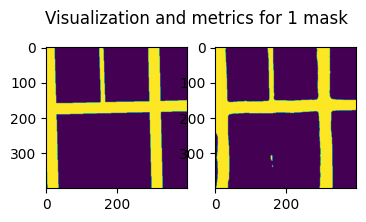

{'Accuracy': 0.95879,
 'Precision': 0.87796,
 'Recall': 0.95668,
 'F1-score': 0.91563}

In [ ]:
print('Predicted mask average:', mask_predictions_unet(model=unet_augmented_rotate, img_directory='data/training/images',
                                                  gt_directory='data/training/groundtruth'))
visualize_predicition_unet(img=im, gt=im_gt_gs, model=unet_augmented_rotate)

data/test_masks/test_1.png
data/test_masks/test_10.png
data/test_masks/test_11.png
data/test_masks/test_12.png
data/test_masks/test_13.png
data/test_masks/test_14.png
data/test_masks/test_15.png
data/test_masks/test_16.png
data/test_masks/test_17.png
data/test_masks/test_18.png
data/test_masks/test_19.png
data/test_masks/test_2.png
data/test_masks/test_20.png
data/test_masks/test_21.png
data/test_masks/test_22.png
data/test_masks/test_23.png
data/test_masks/test_24.png
data/test_masks/test_25.png
data/test_masks/test_26.png
data/test_masks/test_27.png
data/test_masks/test_28.png
data/test_masks/test_29.png
data/test_masks/test_3.png
data/test_masks/test_30.png
data/test_masks/test_31.png
data/test_masks/test_32.png
data/test_masks/test_33.png
data/test_masks/test_34.png
data/test_masks/test_35.png
data/test_masks/test_36.png
data/test_masks/test_37.png
data/test_masks/test_38.png
data/test_masks/test_39.png
data/test_masks/test_4.png
data/test_masks/test_40.png
data/test_masks/test_41.

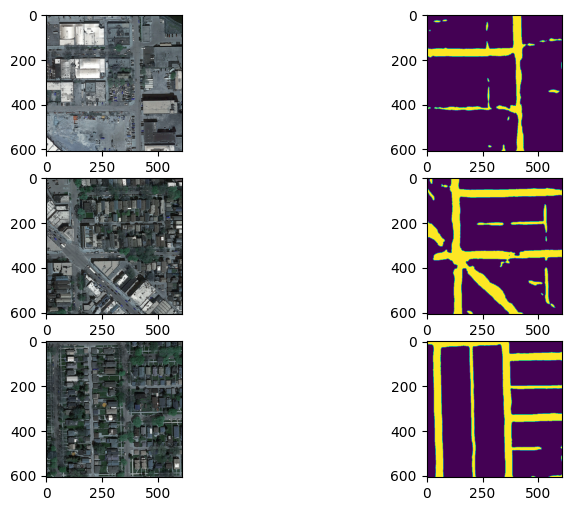

In [ ]:
test_directory = "data/test_set_images/"
predicted_test_masks, mask_filenames = test_masks(test_directory, model = unet_augmented_rotate,
                                                  visualize_number=3)

In [ ]:
#mask_to_submission.masks_to_submission("data/sub003.csv", *mask_filenames)

So after running for 400 epochs, which took a while we got some pretty nice results, which on december 6th got us a 8th place spot in the competition. So the data augmentation and the long number of epochs worked :) score of .867 and augmentation of kaggle dataset with some random 15° splits

#### Preparing the dataset beforehand

In [8]:
def augmented_dataset(augmentation, number = 3, save_path = "data/derivatives/training_images", TRAINING_DIR = "data/training/",
                      filenames = None, keep_OG = True, tiff_diff = False):
  #Create nice image dataset
  for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_filenames = sorted(files)

  if (filenames is not None): training_filenames = filenames

  training_images, training_image_labels = ([], [])
  for fdx, file in enumerate(training_filenames):

      img = cv.imread(TRAINING_DIR+'images/'+file)

      if (not tiff_diff):
        groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file)
      else:
        groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file[:-1])
      #print(groundtruth_mask.shape, groundtruth_mask)
      groundtruth_mask_binary = parse_mask_to_binary(groundtruth_mask)[:,:,None]

      for n in range(number):
        augmented_data = augmentation(image = img, mask = groundtruth_mask_binary)
        training_images.append(augmented_data['image'])
        training_image_labels.append(augmented_data['mask'])

      if (keep_OG):
        training_images.append(img)
        training_image_labels.append(groundtruth_mask_binary)
      if (fdx%20 == 0): print('img number:', fdx)

  training_images = np.array(training_images, dtype=np.uint8)
  training_image_labels = np.array(training_image_labels, dtype = np.uint8)
  #print("dataset shape:", training_images.shape, "labels shape:" ,training_image_labels.shape)

  np.save(f'{save_path}.npy', training_images) #Save data to later not have to rerun this alot
  np.save(f'{save_path}_labels.npy', training_image_labels)
  return "done and saved files"

def data_augmentation_daphne():
    train_transform = [
        album.Rotate(limit=[-180, 180], p=1),
        album.RandomResizedCrop(height=400, width=400, scale=(0.8, 1.0), always_apply=True, p=1),
        ]
    return album.Compose(train_transform)

In [9]:
augmented_dataset(augmentation=data_augmentation_daphne(), number = 1,
                  save_path = "data/derivatives/training_images_daphne_light")

img number: 0
img number: 20
img number: 40
img number: 60
img number: 80


'done and saved files'

In [ ]:
training_imgs = np.load('data/derivatives/training_images_daphne.npy')
training_labels = np.load('data/derivatives/training_images_daphne_labels.npy')

unet_config = {
    "model": "U-Net",
    "patch_size": 8,
    "n_epochs": 50,
    "batch_size": 10,
    "optimizer": "AdamW",
    "loss_function": "BCELoss",
    "learning_rate": 1e-4,
    "prediction_transform": "identity_detach",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.1
}

#unet_augmented = train_model(X=training_imgs, y=training_labels, config=unet_config)

This gave us our best score yet for 50 epochs, on the AIcrowd test set a score of .895

### b) Dataset combining with Masachussets dataset

Small issue with this dataset is that a number of them had these white pixel masks that could really mess up our u-netlearning.

In [5]:
masa_info['im_names'] = masa_info['im_paths'].apply(lambda p: p.split('/')[-1])
masa_info.head(3)

Unnamed: 0                               im_paths  \
0           0  masachussetts/images/10078660_15.tiff   
1           1  masachussetts/images/10078675_15.tiff   
2           2  masachussetts/images/10078690_15.tiff   

                                    ma_paths  white_pixels  corrupted  \
0  masachussetts/groundtruth/10078660_15.tif       2169611       True   
1  masachussetts/groundtruth/10078675_15.tif           128      False   
2  masachussetts/groundtruth/10078690_15.tif         50719      False   

           im_names  
0  10078660_15.tiff  
1  10078675_15.tiff  
2  10078690_15.tiff

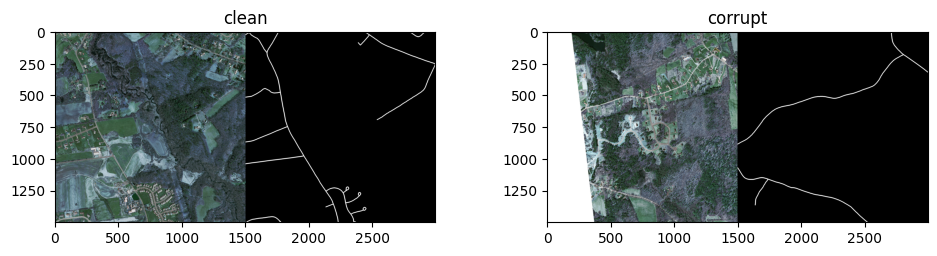

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
choice = np.random.choice(100, size=1)
prepend_path = "data/training/"
corrupted = masa_info[masa_info['corrupted']==True].reset_index(drop=True)
clean = masa_info[masa_info['corrupted']==False].reset_index(drop=True)
#print(prepend_path+corrupted.loc[choice, "im_paths"])
corrupted_im, corrupted_ma = (cv.imread(prepend_path+corrupted.loc[choice, "im_paths"].values.tolist()[0]),
                                 cv.imread(prepend_path+corrupted.loc[choice, "ma_paths"].values.tolist()[0]))
corrupted_cat = np.concatenate([corrupted_im, corrupted_ma], axis = 1)
clean_im, clean_ma = (cv.imread(prepend_path+clean.loc[choice, "im_paths"].values.tolist()[0]),
                      cv.imread(prepend_path+clean.loc[choice, "ma_paths"].values.tolist()[0]))

#aug = data_augmentation_masa()(image=clean_im, mask = clean_ma)
#clean_im, clean_ma = aug['image'], aug['mask']
clean_cat = np.concatenate([clean_im, clean_ma], axis = 1)

ax[0].imshow(clean_cat)
ax[1].imshow(corrupted_cat)
ax[0].set_title('clean')
ax[1].set_title('corrupt')
plt.tight_layout()
plt.show()

In [4]:
#prepare masachussets dataset
masachussetts_number = 300
#filenames = clean['im_names'].values.tolist()[:masachussetts_number] #take n_images
#Running the following commented function takes about 20minutes on colab

#augmented_dataset(augmentation = data_augmentation_masa(), number = 1,
#                  save_path = "data/derivatives/training_images_masa",
#                  TRAINING_DIR = "data/training/masachussetts/", filenames = filenames, keep_OG = False, tiff_diff = True)

training_imgs_augmented = np.load('data/derivatives/training_images_daphne.npy')
training_labels_augmented = np.load('data/derivatives/training_images_daphne_labels.npy')

training_imgs_masa = np.load('data/derivatives/training_images_masa.npy')
training_labels_masa = np.load('data/derivatives/training_images_masa_labels.npy')

training_imgs_combined = np.concatenate([training_imgs_masa, training_imgs_augmented], axis = 0)
training_labels_combined = np.concatenate([training_labels_masa, training_labels_augmented], axis = 0)

print(training_imgs_combined.shape, training_labels_combined.shape)

(700, 400, 400, 3) (700, 400, 400, 1)


In [ ]:
#We have a 700 image dataset now, which is cool, masachussetts are 99% zoomed in and poorer quality so this could
#work against us

In [5]:
unet_config_mas = {
    "model": "U-Net",
    "patch_size": 8,
    "n_epochs": 20,
    "batch_size": 5,
    "optimizer": "AdamW",
    "loss_function": "BCELoss",
    "learning_rate": 1e-4,
    "prediction_transform": "binarize",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.1,
    "validate_every": 5
}

print("number of params unet:", human_readable(count_parameters(model = UNET())))

unet_mas, metrics_per_epoch_mas = train_model(X = training_imgs_combined, y = training_labels_combined,
                                              config = unet_config_mas)

number of params unet: 31.04M
X_train shape: (630, 400, 400, 3) (630, 400, 400, 1)
Epoch: 005 train loss = 0.261067 val loss = 0.235718 train accuracy = 0.9101 val accuracy = 0.9176 validation F1 0.6646
Epoch: 010 train loss = 0.175246 val loss = 0.190488 train accuracy = 0.9375 val accuracy = 0.9290 validation F1 0.7411
Epoch: 015 train loss = 0.144613 val loss = 0.176413 train accuracy = 0.9462 val accuracy = 0.9331 validation F1 0.7538
Epoch: 020 train loss = 0.119822 val loss = 0.168050 train accuracy = 0.9549 val accuracy = 0.9362 validation F1 0.7881


Data is too different from our training and test sets in terms of image the scale is too different. Maybe we can try different data preparations with different albumentations

Predicted mask average: {'Accuracy': 0.9592498749999998, 'F1-score': 0.9046854154581402}


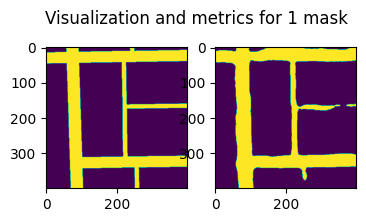

{'Accuracy': 0.94099375,
 'Precision': 0.8468209333276091,
 'Recall': 0.944797030295773,
 'F1-score': 0.8931300302237919}

In [8]:
print('Predicted mask average:', mask_predictions_unet(model=unet_mas, img_directory='data/training/images',
                                                          gt_directory='data/training/groundtruth'))
visualize_predicition_unet(img=im, gt=im_gt_gs, model=unet_mas)

data/test_masks/test_1.png
data/test_masks/test_10.png
data/test_masks/test_11.png
data/test_masks/test_12.png
data/test_masks/test_13.png
data/test_masks/test_14.png
data/test_masks/test_15.png
data/test_masks/test_16.png
data/test_masks/test_17.png
data/test_masks/test_18.png
data/test_masks/test_19.png
data/test_masks/test_2.png
data/test_masks/test_20.png
data/test_masks/test_21.png
data/test_masks/test_22.png
data/test_masks/test_23.png
data/test_masks/test_24.png
data/test_masks/test_25.png
data/test_masks/test_26.png
data/test_masks/test_27.png
data/test_masks/test_28.png
data/test_masks/test_29.png
data/test_masks/test_3.png
data/test_masks/test_30.png
data/test_masks/test_31.png
data/test_masks/test_32.png
data/test_masks/test_33.png
data/test_masks/test_34.png
data/test_masks/test_35.png
data/test_masks/test_36.png
data/test_masks/test_37.png
data/test_masks/test_38.png
data/test_masks/test_39.png
data/test_masks/test_4.png
data/test_masks/test_40.png
data/test_masks/test_41.

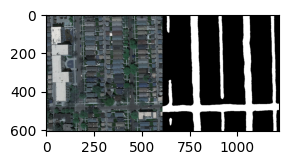

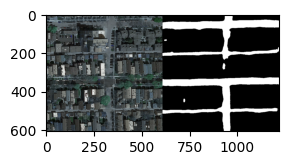

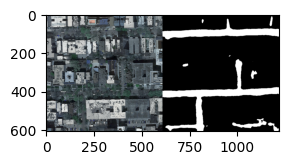

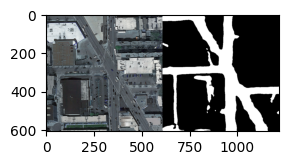

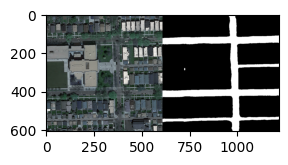

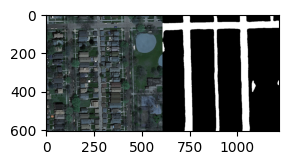

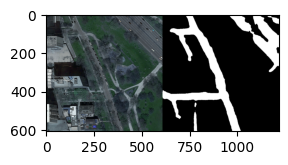

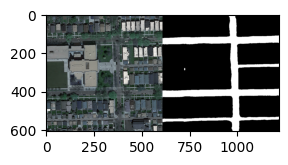

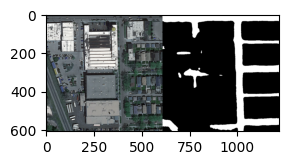

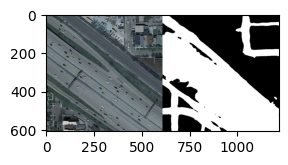

In [11]:
test_directory = "data/test_set_images/"
predicted_test_masks, mask_filenames = test_masks(test_directory, model = unet_mas,
                                                  visualize_number=10)

In [13]:
# for only 20 epochs this is a great result

### c) combinig Ottawa dataset

We will try combining a light version of the daphne augmented dataset and the ottawa dataset, which each image has been cropped and resized. This total dataset gives us 300 images which are pretty unique

In [11]:
training_imgs_augmented_light = np.load('data/derivatives/training_images_daphne_light.npy')
training_labels_augmented_light = np.load('data/derivatives/training_images_daphne_light_labels.npy')

training_imgs_otta = np.load('data/derivatives/training_images_otta.npy')
training_labels_otta = np.load('data/derivatives/training_images_otta_labels.npy')

training_imgs_combined_2 = np.concatenate([training_imgs_otta, training_imgs_augmented_light], axis = 0)
training_labels_combined_2 = np.concatenate([training_labels_otta, training_labels_augmented_light], axis = 0)

print(training_imgs_combined_2.shape, training_labels_combined_2.shape)

(300, 400, 400, 3) (300, 400, 400, 1)


In [12]:
unet_config_otta = {
    "model": "U-Net",
    "patch_size": 8,
    "n_epochs": 20,
    "batch_size": 5,
    "optimizer": "AdamW",
    "loss_function": "BCELoss",
    "learning_rate": 1e-4,
    "prediction_transform": "binarize",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.05,
    "validate_every": 5
}

#Using unet64 architecture

unet_otta, metrics_per_epoch_otta = train_model(X = training_imgs_combined_2, y = training_labels_combined_2,
                                              config = unet_config_otta)

X_train shape: (285, 400, 400, 3) (285, 400, 400, 1)
Epoch: 005 train loss = 0.260791 val loss = 0.277184 train accuracy = 0.9111 val accuracy = 0.8960 validation F1 0.7644
Epoch: 010 train loss = 0.179475 val loss = 0.231007 train accuracy = 0.9401 val accuracy = 0.9095 validation F1 0.8080
Epoch: 015 train loss = 0.137711 val loss = 0.195225 train accuracy = 0.9531 val accuracy = 0.9242 validation F1 0.8269
Epoch: 020 train loss = 0.107210 val loss = 0.192041 train accuracy = 0.9627 val accuracy = 0.9255 validation F1 0.8315


Predicted mask average: {'Accuracy': 0.9597496875000001, 'F1-score': 0.8966046551477426}


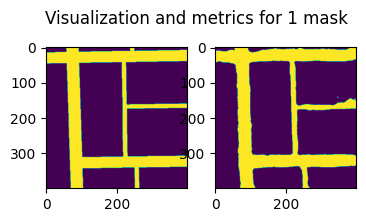

{'Accuracy': 0.9497,
 'Precision': 0.8691167130248144,
 'Recall': 0.9503772003352892,
 'F1-score': 0.9079323678129362}

In [13]:
print('Predicted mask average:', mask_predictions_unet(model=unet_otta, img_directory='data/training/images',
                                                          gt_directory='data/training/groundtruth'))
visualize_predicition_unet(img=im, gt=im_gt_gs, model=unet_otta)

data/test_masks/test_1.png
data/test_masks/test_14.png
data/test_masks/test_19.png
data/test_masks/test_23.png
data/test_masks/test_28.png
data/test_masks/test_32.png
data/test_masks/test_37.png
data/test_masks/test_41.png
data/test_masks/test_46.png
data/test_masks/test_50.png


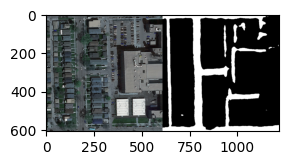

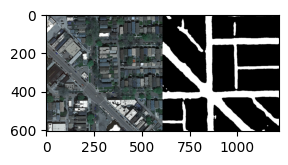

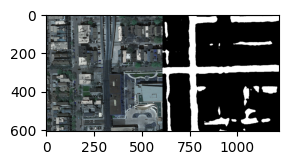

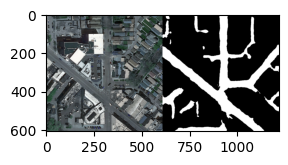

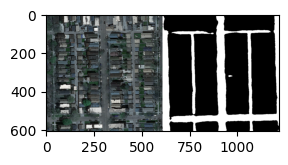

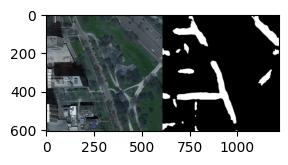

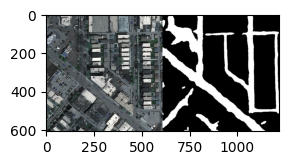

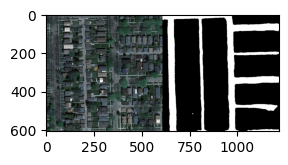

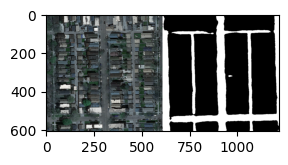

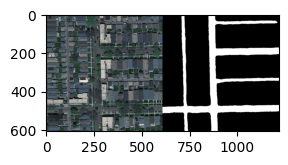

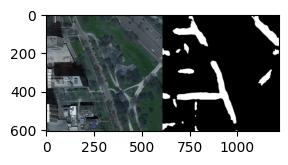

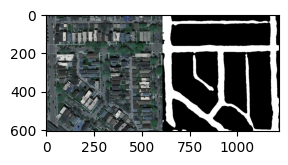

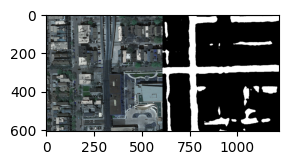

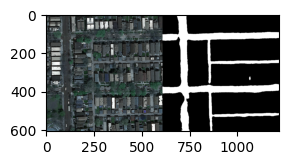

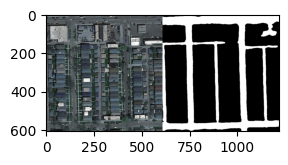

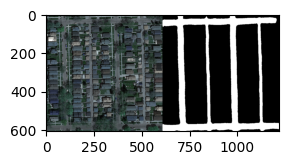

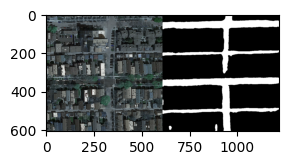

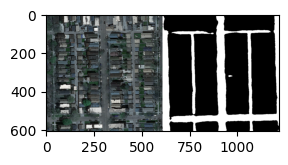

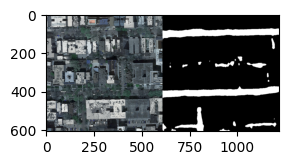

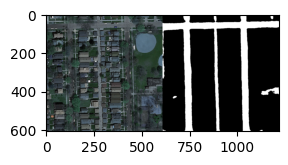

In [17]:
test_directory = "data/test_set_images/"
predicted_test_masks, mask_filenames = test_masks(test_directory, model = unet_otta,
                                                  visualize_number=20)

## 6) Favorite Model Variations

So we figured out our best model is going to be the U-Net

So we will try different things for this U-Net, We won't do a full factorial comparison however we will run our original U-Net with different modifications:

- different loss functions
- different convolutional neural network depth and density
- regularization techniques such as weight decay

### i) Loss Functions


#### a) Dice Loss

We try sorensen dice loss, code in training.py script

In [ ]:
training_imgs = np.load('data/derivatives/training_images_daphne.npy')
training_labels = np.load('data/derivatives/training_images_daphne_labels.npy')

In [ ]:
unet_dice = {
    "model": "U-Net",
    "patch_size": 8,
    "n_epochs": 50,
    "batch_size": 8,
    "optimizer": "AdamW",
    "loss_function": "Dice",
    "learning_rate": 1e-4,
    "prediction_transform": "binarize",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.1,
    "validate_every": 1
}

unet_dice, dice_metrics = train_model(X=training_imgs, y=training_labels, config=unet_dice)

X_train shape: (360, 400, 400, 3) (360, 400, 400, 1)
Epoch: 001 train loss = 0.554130 val loss = 0.550690 train accuracy = 0.6413 val accuracy = 0.6151 validation F1 0.2431
Epoch: 002 train loss = 0.437222 val loss = 0.438394 train accuracy = 0.7919 val accuracy = 0.5846 validation F1 0.2695
Epoch: 003 train loss = 0.400586 val loss = 0.421357 train accuracy = 0.8181 val accuracy = 0.5940 validation F1 0.2702
Epoch: 004 train loss = 0.363508 val loss = 0.417001 train accuracy = 0.8423 val accuracy = 0.5671 validation F1 0.2787
Epoch: 005 train loss = 0.338956 val loss = 0.359844 train accuracy = 0.8607 val accuracy = 0.5921 validation F1 0.2852
Epoch: 006 train loss = 0.324579 val loss = 0.330482 train accuracy = 0.8698 val accuracy = 0.6231 validation F1 0.2274
Epoch: 007 train loss = 0.305944 val loss = 0.324180 train accuracy = 0.8908 val accuracy = 0.6382 validation F1 0.2288
Epoch: 008 train loss = 0.287494 val loss = 0.339298 train accuracy = 0.9026 val accuracy = 0.6316 validati

Predicted mask average: {'Accuracy': 0.9727334375, 'F1-score': 0.9378982858584854}


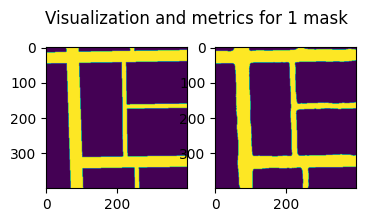

{'Accuracy': 0.96631875,
 'Precision': 0.8871853839274307,
 'Recall': 0.9978206202849959,
 'F1-score': 0.939256286844686}

In [ ]:
print('Predicted mask average:', mask_predictions_unet(model=unet_dice, img_directory='data/training/images',
                                                  gt_directory='data/training/groundtruth'))
visualize_predicition_unet(img=im, gt=im_gt_gs, model=unet_dice)

data/test_masks/test_1.png
data/test_masks/test_10.png
data/test_masks/test_11.png
data/test_masks/test_12.png
data/test_masks/test_13.png
data/test_masks/test_14.png
data/test_masks/test_15.png
data/test_masks/test_16.png
data/test_masks/test_17.png
data/test_masks/test_18.png
data/test_masks/test_19.png
data/test_masks/test_2.png
data/test_masks/test_20.png
data/test_masks/test_21.png
data/test_masks/test_22.png
data/test_masks/test_23.png
data/test_masks/test_24.png
data/test_masks/test_25.png
data/test_masks/test_26.png
data/test_masks/test_27.png
data/test_masks/test_28.png
data/test_masks/test_29.png
data/test_masks/test_3.png
data/test_masks/test_30.png
data/test_masks/test_31.png
data/test_masks/test_32.png
data/test_masks/test_33.png
data/test_masks/test_34.png
data/test_masks/test_35.png
data/test_masks/test_36.png
data/test_masks/test_37.png
data/test_masks/test_38.png
data/test_masks/test_39.png
data/test_masks/test_4.png
data/test_masks/test_40.png
data/test_masks/test_41.

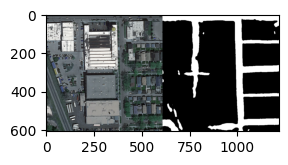

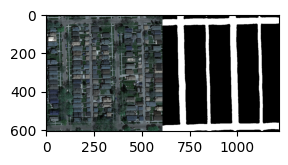

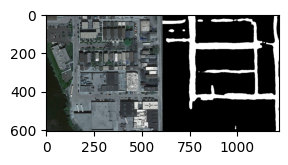

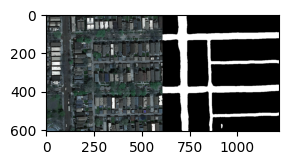

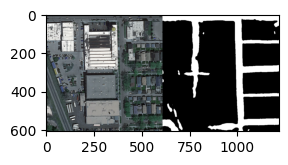

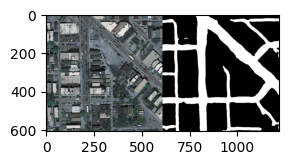

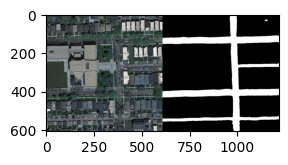

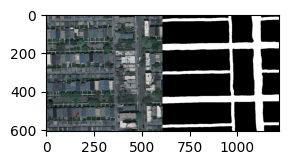

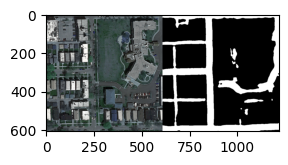

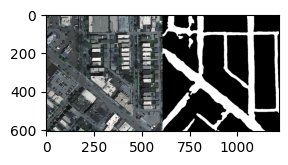

In [ ]:
test_directory = "data/test_set_images/"
predicted_test_masks, mask_filenames = test_masks(test_directory, model = unet_dice,
                                                  visualize_number=10)

In [ ]:
#torch.save(unet_dice.state_dict(), "data/derivatives/unet_dice.pth")

AttributeError: ignored

#### b) Focal Loss


In [ ]:
unet_focal_config = {
    "model": "U-Net",
    "patch_size": 8,
    "n_epochs": 50,
    "batch_size": 8,
    "optimizer": "AdamW",
    "loss_function": "binaryFocal",
    "learning_rate": 1e-4,
    "prediction_transform": "binarize",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.1,
    "validate_every": 1
}

unet_focal, focal_metrics = train_model(X=training_imgs, y=training_labels, config=unet_focal_config)

X_train shape: (360, 400, 400, 3) (360, 400, 400, 1)
Epoch: 001 train loss = 0.064171 val loss = 0.062669 train accuracy = 0.7793 val accuracy = 0.6677 validation F1 0.1916
Epoch: 002 train loss = 0.055352 val loss = 0.053375 train accuracy = 0.8457 val accuracy = 0.7224 validation F1 0.1283
Epoch: 003 train loss = 0.052353 val loss = 0.052840 train accuracy = 0.8652 val accuracy = 0.7059 validation F1 0.1773
Epoch: 004 train loss = 0.050412 val loss = 0.051229 train accuracy = 0.8778 val accuracy = 0.7336 validation F1 0.1488
Epoch: 005 train loss = 0.049042 val loss = 0.050999 train accuracy = 0.8856 val accuracy = 0.6671 validation F1 0.1993
Epoch: 006 train loss = 0.047995 val loss = 0.047802 train accuracy = 0.8912 val accuracy = 0.6980 validation F1 0.1586
Epoch: 007 train loss = 0.046938 val loss = 0.046852 train accuracy = 0.9019 val accuracy = 0.6875 validation F1 0.1640
Epoch: 008 train loss = 0.046003 val loss = 0.046534 train accuracy = 0.9081 val accuracy = 0.7065 validati

Predicted mask average: {'Accuracy': 0.9691771874999995, 'F1-score': 0.9101047434736746}


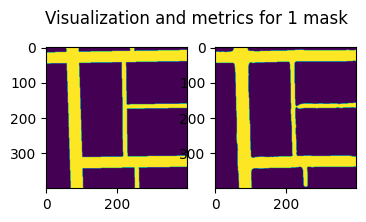

{'Accuracy': 0.97661875,
 'Precision': 0.949656967116158,
 'Recall': 0.9613698958208597,
 'F1-score': 0.9554775364474858}

In [ ]:
print('Predicted mask average:', mask_predictions_unet(model=unet_focal, img_directory='data/training/images',
                                                          gt_directory='data/training/groundtruth'))
visualize_predicition_unet(img=im, gt=im_gt_gs, model=unet_focal)

data/test_masks/test_1.png
data/test_masks/test_10.png
data/test_masks/test_11.png
data/test_masks/test_12.png
data/test_masks/test_13.png
data/test_masks/test_14.png
data/test_masks/test_15.png
data/test_masks/test_16.png
data/test_masks/test_17.png
data/test_masks/test_18.png
data/test_masks/test_19.png
data/test_masks/test_2.png
data/test_masks/test_20.png
data/test_masks/test_21.png
data/test_masks/test_22.png
data/test_masks/test_23.png
data/test_masks/test_24.png
data/test_masks/test_25.png
data/test_masks/test_26.png
data/test_masks/test_27.png
data/test_masks/test_28.png
data/test_masks/test_29.png
data/test_masks/test_3.png
data/test_masks/test_30.png
data/test_masks/test_31.png
data/test_masks/test_32.png
data/test_masks/test_33.png
data/test_masks/test_34.png
data/test_masks/test_35.png
data/test_masks/test_36.png
data/test_masks/test_37.png
data/test_masks/test_38.png
data/test_masks/test_39.png
data/test_masks/test_4.png
data/test_masks/test_40.png
data/test_masks/test_41.

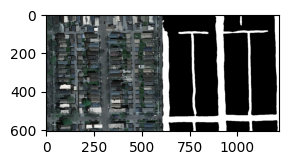

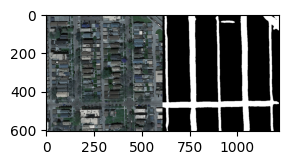

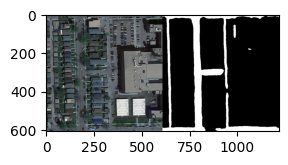

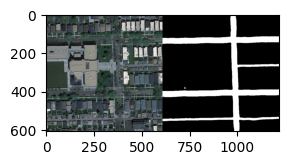

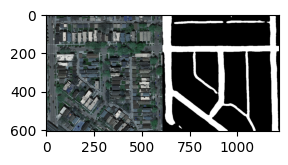

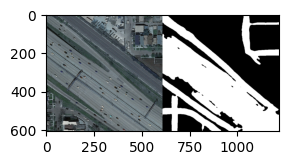

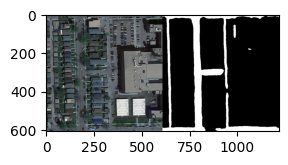

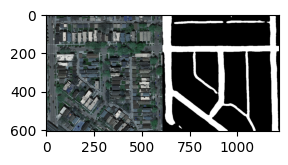

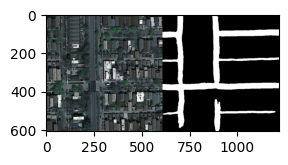

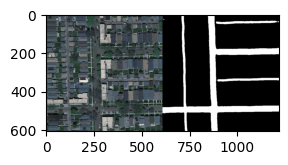

In [ ]:
test_directory = "data/test_set_images/"
predicted_test_masks, mask_filenames = test_masks(test_directory, model = unet_focal,
                                                  visualize_number=10)

In [ ]:
mask_to_submission.masks_to_submission("data/derivatives/sub_focal.csv", *mask_filenames)

In [ ]:
#### b) Focal Loss
#### c) Loss Megatron


#### c) Fraud Loss

This loss is combining BCE & Dice Loss

In [3]:
training_imgs_augmented_light = np.load('data/derivatives/training_images_daphne_light.npy')
training_labels_augmented_light = np.load('data/derivatives/training_images_daphne_light_labels.npy')

In [4]:
unet_fraud_config = {
    "model": "U-Net",
    "patch_size": 8,
    "n_epochs": 20,
    "batch_size": 5,
    "optimizer": "AdamW",
    "loss_function": "FraudLoss",
    "learning_rate": 1e-4,
    "prediction_transform": "binarize",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.1,
    "validate_every": 5
}

unet_fraud, fraud_metrics = train_model(X=training_imgs_augmented_light,
                                        y=training_labels_augmented_light, config=unet_fraud_config)

X_train shape: (180, 400, 400, 3) (180, 400, 400, 1)
Epoch: 005 train loss = 0.836161 val loss = 0.805807 train accuracy = 0.8504 val accuracy = 0.8384 validation F1 0.7468
Epoch: 010 train loss = 0.626077 val loss = 0.754432 train accuracy = 0.9196 val accuracy = 0.8593 validation F1 0.7828
Epoch: 015 train loss = 0.480773 val loss = 0.495701 train accuracy = 0.9443 val accuracy = 0.9265 validation F1 0.8630
Epoch: 020 train loss = 0.379765 val loss = 0.474184 train accuracy = 0.9575 val accuracy = 0.9172 validation F1 0.8536


### ii) Architecture variations

We can look at comparing 4 different models

In [5]:
unet_config_basic = {
    "model": "U-Net",
    "patch_size": 8,
    "n_epochs": 50,
    "batch_size": 8,
    "optimizer": "AdamW",
    "loss_function": "BCELoss",
    "learning_rate": 1e-4,
    "prediction_transform": "binarize",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.1,
    "validate_every": 5
}

unet32 = UNET(features=[32, 64, 128, 256]).to(device=DEVICE) #light unet
#unet64 = UNET(features=[64, 128, 256, 512]).to(device=DEVICE) #standard unet
smooth_unet = UNET(features=[32, 64, 128, 256, 512]).to(device=DEVICE)
fat_unet = UNET(features=[32, 64, 128, 256, 512, 1024]).to(device=DEVICE)
double_unet32 = UNET(features=[32, 32, 64, 64, 128, 128, 256, 256])

print("number of params unet32:", human_readable(count_parameters(model = unet32)))
#print("number of params unet64:", human_readable(count_parameters(model = unet64)))
print("number of params double unet:", human_readable(count_parameters(model = double_unet32)))
print("number of params smooth unet:", human_readable(count_parameters(model = smooth_unet)))
print("number of params fat unet:", human_readable(count_parameters(model = fat_unet)))

number of params unet32: 7.76M
number of params double unet: 12.38M
number of params smooth unet: 31.10M
number of params fat unet: 124.44M


#### a) unet32 light model

In [26]:
unet32, metrics_per_epoch_unet32 = train_model(X = training_imgs_augmented, y = training_labels_augmented,
                                              config = unet_config_basic, use_model = unet32)

X_train shape: (360, 400, 400, 3) (360, 400, 400, 1)
Epoch: 005 train loss = 0.497928 val loss = 0.486183 train accuracy = 0.8724 val accuracy = 0.8791 validation F1 0.7624
Epoch: 010 train loss = 0.419320 val loss = 0.438140 train accuracy = 0.9149 val accuracy = 0.8831 validation F1 0.7822
Epoch: 015 train loss = 0.361379 val loss = 0.376018 train accuracy = 0.9364 val accuracy = 0.9215 validation F1 0.8361
Epoch: 020 train loss = 0.309080 val loss = 0.336632 train accuracy = 0.9582 val accuracy = 0.9388 validation F1 0.8610


Predicted mask average: {'Accuracy': 0.9640276875000005, 'F1-score': 0.9118193231275837}


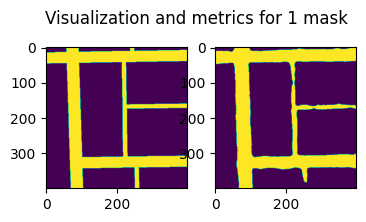

{'Accuracy': 0.9570875,
 'Precision': 0.8835220402330438,
 'Recall': 0.9624476110645431,
 'F1-score': 0.9212975699220541}

In [27]:
print('Predicted mask average:', mask_predictions_unet(model=unet32, img_directory='data/training/images',
                                                          gt_directory='data/training/groundtruth'))
visualize_predicition_unet(img=im, gt=im_gt_gs, model=unet32)

data/test_masks/test_1.png
data/test_masks/test_14.png
data/test_masks/test_19.png
data/test_masks/test_23.png
data/test_masks/test_28.png
data/test_masks/test_32.png
data/test_masks/test_37.png
data/test_masks/test_41.png
data/test_masks/test_46.png
data/test_masks/test_50.png


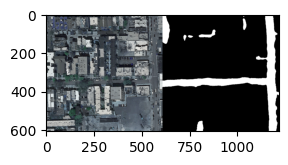

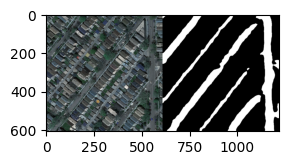

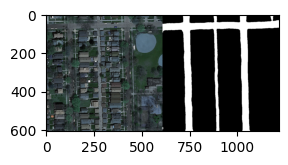

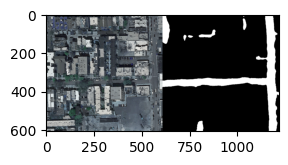

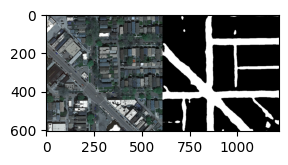

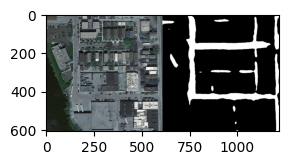

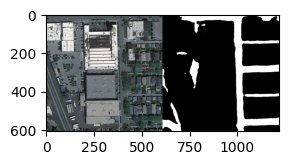

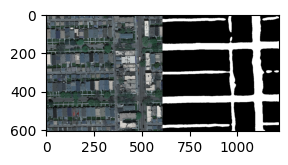

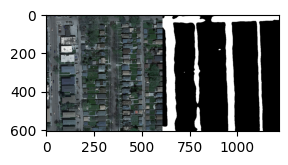

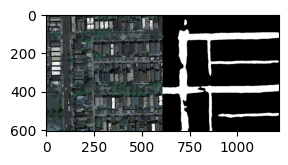

In [42]:
test_directory = "data/test_set_images/"
predicted_test_masks, mask_filenames = test_masks(test_directory, model = unet32,
                                                  visualize_number=10)

### iii) Regularization

L2- regularization, goes directly into the optimizer and basically adds a softening $\lambda$ term to the gradient descent step. We can try for the different values: 1e-6 to 1e-2

In [2]:
unet_config_basic = {
    "model": "U-Net",
    "patch_size": 8,
    "n_epochs": 50,
    "batch_size": 8,
    "optimizer": "AdamW",
    "loss_function": "BCELoss",
    "learning_rate": 1e-4,
    "prediction_transform": "binarize",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.1,
    "validate_every": 5,
    "weight_decay": 1e-5
}

NameError: ignored

## 7) Transfer Learning

After reading a bit on the literature, we see that DeepLabv3 is a great pretrained model that can semantically segment extremely well, so we will try load this model's pretrained weights and define a new prediction head and train this model having frozen its backbone for a certain amount of epochs

In [3]:
training_imgs = np.load('data/derivatives/training_images_daphne_light.npy')
training_labels = np.load('data/derivatives/training_images_daphne_light_labels.npy')

X = training_imgs
y = training_labels
print(X.shape, y.shape)

(200, 400, 400, 3) (200, 400, 400, 1)


In [16]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=.01, shuffle=True)


batch_size = 5
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=torch.cuda.is_available(),
                              drop_last = False, num_workers = 2) #create train data loader

validation_dataset = TensorDataset(torch.tensor(X_validation, dtype=torch.float32), torch.tensor(y_validation, dtype=torch.float32))
validation_loader = DataLoader(validation_dataset, batch_size=batch_size) #create


def create_deeplabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(256, outputchannels, kernel_size=(1,1), stride=(1,1))
    return model

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab = create_deeplabv3().to(device)

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(deeplab.parameters(), lr=7*1e-5)

num_epochs = 25
for epoch in range(num_epochs):
    deeplab.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        images, masks = permutate_labels(images), permutate_labels(masks)

        optimizer.zero_grad()
        output = deeplab(images)['out']

        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.4495919346809387
Epoch 2, Loss: 0.2777412235736847
Epoch 3, Loss: 0.22265252470970154
Epoch 4, Loss: 0.19055183231830597
Epoch 5, Loss: 0.19583752751350403
Epoch 6, Loss: 0.1468610316514969
Epoch 7, Loss: 0.1492817997932434
Epoch 8, Loss: 0.11326364427804947
Epoch 9, Loss: 0.129865363240242
Epoch 10, Loss: 0.11328484863042831
Epoch 11, Loss: 0.10629580169916153
Epoch 12, Loss: 0.09856804460287094
Epoch 13, Loss: 0.09630154818296432
Epoch 14, Loss: 0.08834519982337952
Epoch 15, Loss: 0.09723740071058273
Epoch 16, Loss: 0.0951036810874939
Epoch 17, Loss: 0.07523535192012787
Epoch 18, Loss: 0.0764620304107666
Epoch 19, Loss: 0.08140601962804794
Epoch 20, Loss: 0.07948426157236099
Epoch 21, Loss: 0.0693282037973404
Epoch 22, Loss: 0.06315110623836517
Epoch 23, Loss: 0.06962425261735916
Epoch 24, Loss: 0.08548779040575027
Epoch 25, Loss: 0.06841108947992325


torch.Size([1, 3, 608, 608])
data/test_masks/test_1.png
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
data/test_masks/test_14.png
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
data/test_masks/test_19.png
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
data/test_masks/test_23.png
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
data/test_masks/test_28.png
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
data/test_masks/test_32.png
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608, 608])
torch.Size([1, 3, 608

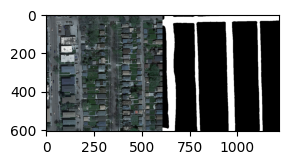

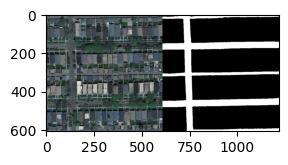

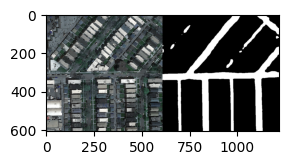

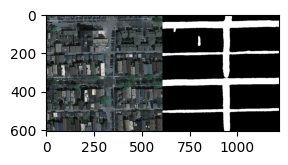

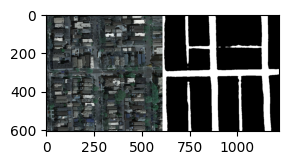

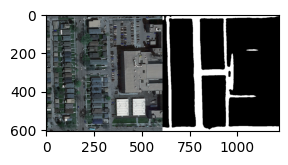

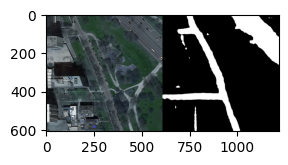

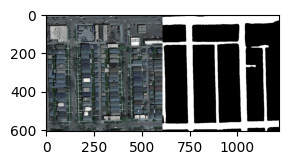

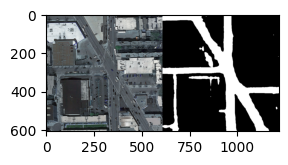

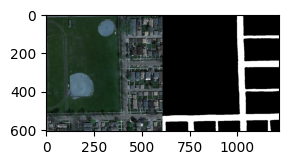

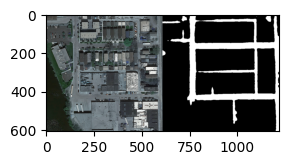

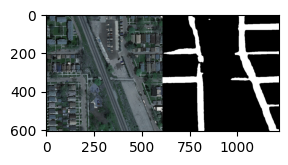

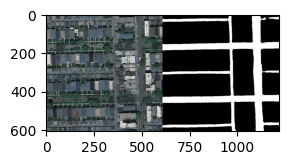

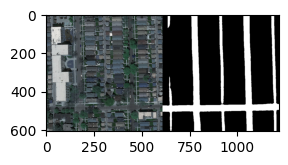

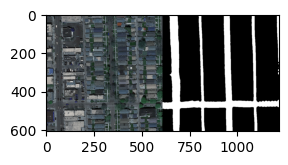

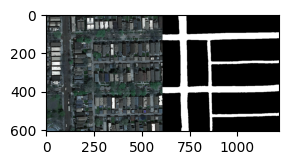

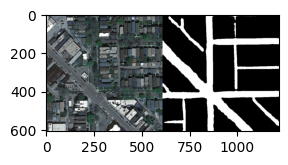

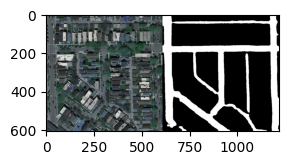

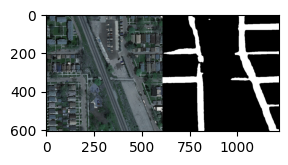

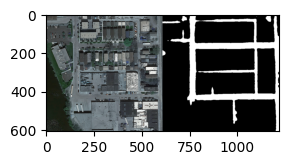

In [33]:
test_directory = "data/test_set_images/"
predicted_test_masks, mask_filenames = test_masks(test_directory, model = deeplab,
                                                  visualize_number=20, deep=True)

In [35]:
mask_to_submission.masks_to_submission("data/sub_deeplab.csv", *mask_filenames)

In [37]:
#torch.save(deeplab.state_dict(), 'data/deeplab.pth')

## 8) Experiments

In [3]:
training_imgs_augmented_light = np.load('data/derivatives/training_images_daphne_light.npy')
training_labels_augmented_light = np.load('data/derivatives/training_images_daphne_light_labels.npy')

training_imgs_ottab = np.load('data/derivatives/training_images_otta_better.npy')
training_labels_ottab = np.load('data/derivatives/training_images_otta_better_labels.npy')

training_imgs_combined = np.concatenate([training_imgs_ottab, training_imgs_augmented_light], axis = 0)
training_labels_combined = np.concatenate([training_labels_ottab, training_labels_augmented_light], axis = 0)

print(training_imgs_combined.shape, training_labels_combined.shape)

(400, 400, 400, 3) (400, 400, 400, 1)


In [ ]:
unet_config_1 = {
    "model": "U-Net",
    "patch_size": 8,
    "n_epochs": 50,
    "batch_size": 5,
    "optimizer": "AdamW",
    "loss_function": "FraudLoss",
    "learning_rate": 1e-4,
    "prediction_transform": "binarize",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.05,
    "validate_every": 5,
    "dataset":  "daphne light & otta better"
}

unet32 = UNET(features=[32, 64, 128, 256]).to(device=DEVICE) #light unet
print("number of params unet32:", human_readable(count_parameters(model = unet32)))

unet32, metrics_per_epoch_config_1 = train_model(X = training_imgs_combined,
                                               y = training_labels_combined,
                                               config = unet_config_1, use_model = unet32)

number of params unet32: 7.76M
X_train shape: (380, 400, 400, 3) (380, 400, 400, 1)
Epoch: 005 train loss = 0.826691 val loss = 0.833006 train accuracy = 0.9236 val accuracy = 0.9226 validation F1 0.7690
Epoch: 010 train loss = 0.611698 val loss = 0.694059 train accuracy = 0.9534 val accuracy = 0.9291 validation F1 0.7997
Epoch: 015 train loss = 0.473425 val loss = 0.579536 train accuracy = 0.9620 val accuracy = 0.9358 validation F1 0.8137
Epoch: 020 train loss = 0.354873 val loss = 0.499768 train accuracy = 0.9705 val accuracy = 0.9416 validation F1 0.8403
Epoch: 025 train loss = 0.270438 val loss = 0.536787 train accuracy = 0.9755 val accuracy = 0.9245 validation F1 0.7995
